# Spatialisation : Interpolation des données du clients 


Ce notebook présente l'utilisation du modèle bi-dimensionnel du champ pour une meilleure répartitions des observations de Soil Moisture

In [59]:
%matplotlib inline
#%matplotlib widget 
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from spatial import Spatial_grid, HumidityData
import csv
import pandas as pd

Lecture des données d'humidité pour chacune des sondes

In [60]:
canons_data = []
for k in range(1, 7):
    canon = HumidityData(f'data/Data 2022/Probes/Sonde Canon {k}.csv')
    canon.read_data()
    canons_data.append(canon.get_humidity_values())


Données spatiales de la localisation des sondes en coordonnées (x,y) dans le champ.

Les coordonnées en z représentent l'humidité localement en (x,y) obtenue avec les mesures des sondes Canon.

In [61]:
coord_conon1 = [0,0]
coord_conon2 = [10,12]
coord_conon3 = [9,5]
coord_conon4 = [2,5]
coord_conon5 = [4,11]
coord_conon6 = [6,1]

np.random.seed(3)

random_coords = [(np.random.uniform(0, 10), np.random.uniform(0, 10)) for _ in range(6)]

coord_x = [coord_conon1[0], coord_conon2[0], coord_conon3[0], coord_conon4[0], coord_conon5[0], coord_conon6[0]]
coord_y = [coord_conon1[1], coord_conon2[1], coord_conon3[1], coord_conon4[1], coord_conon5[1], coord_conon6[1]]
#coord_x = [random_coords[i][0] for i in range(6)]
#coord_y = [random_coords[i][1] for i in range(6)]

k = 1300
coord_z = [canons_data[i]['humidity6'][k] for i in range(6)]

In [62]:
print('Date : ',canons_data[1]['time'][k]) # date de la mesure

Date :  2022-07-25 18:00:00


La classe Spatial_grid permet d'effectuer multiples opérations spatiales à partir des données des coordonnées (x,y) des sondes et de l'humidité localement mesurée

## Linear Interpolation

Une première approche d'estimer les valeurs d'humidité entre les sondes est l'interpolation linéaire qui forme des 'triangles' en traçant des droites entre les 3 sondes les plus prochent, ce qui forme une figure 3D de valeurs d'humidité entre les sondes

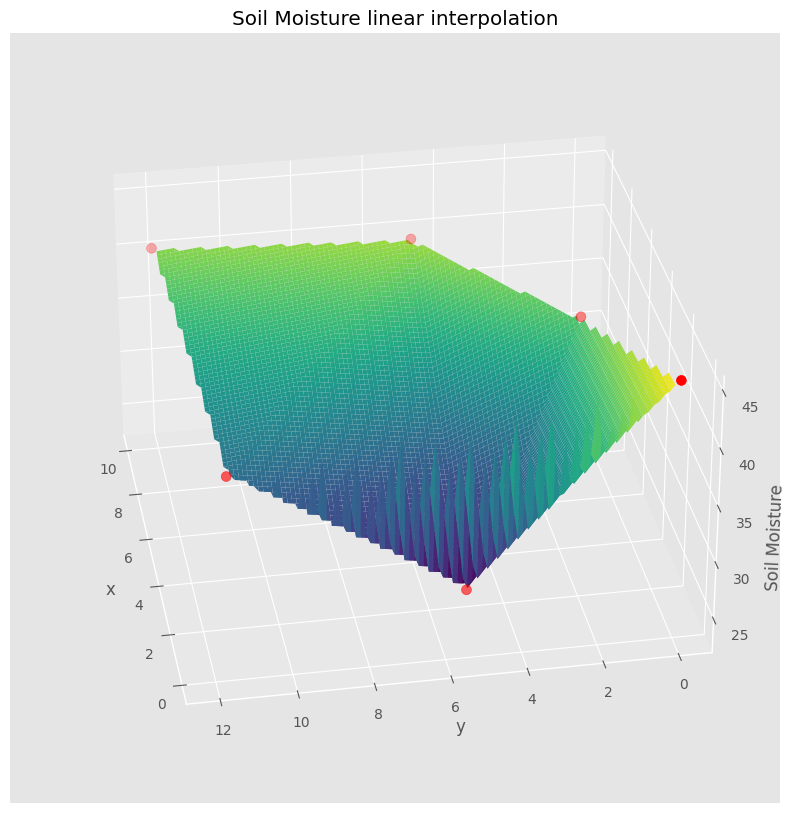

In [63]:
canon_grid_linear = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid_linear.plot(cmap='viridis', method='linear', azim= 170, elev= 30, color_bar=False, box_aspect=[1, 1, 0.6])

## Nearest Neighbor Interpolation and Extrapolation

Le modèle linéaire est limité à l'interpolation et ne permet pas d'avoir de données externes à la zone délimitée par les sondes.

Mais une extrapolation en plus de l'interpolation peut être faite avec le modèle Nearest-Neighbor qui forme des plateaux en attribuant à chaque coordonnées la valeur d'humidité de la sonde la plus proche

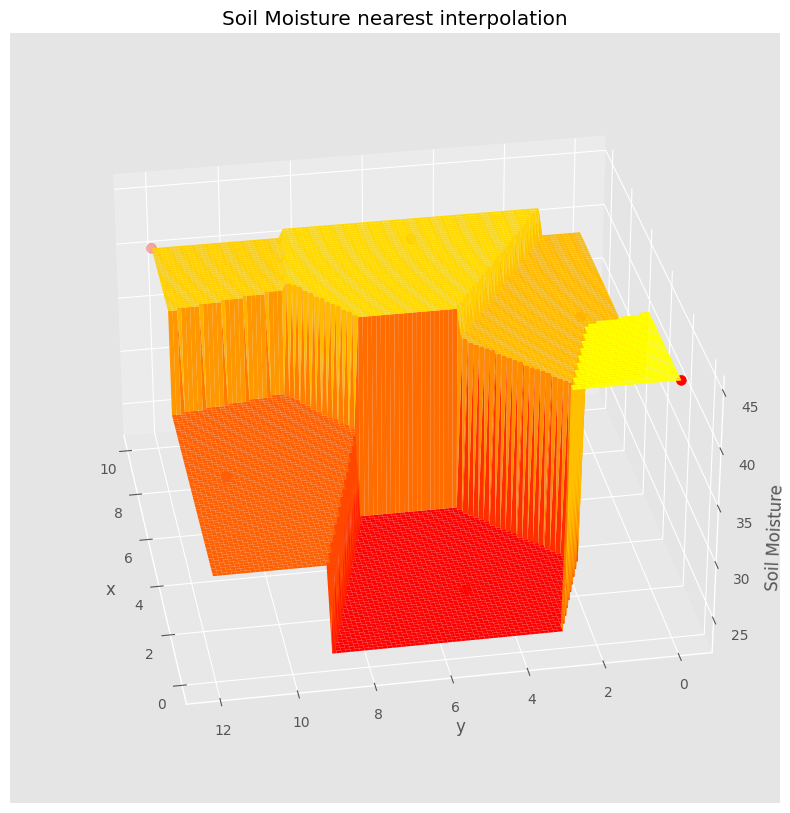

In [64]:
canon_grid_near = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid_near.plot(cmap='autumn', method='nearest', azim= 170, elev= 30, color_bar=False, box_aspect=[1, 1, 0.6])

## Combined Nearest Neighbor extrapolation and Linear Interpolation

En combinant le modèle linéaire et NN, on peut estimer une valeur d'humidité sur l'ensemble du champ malgré le peu de sondes disponibles.

Le modèle NN sert à extrapoler les valeurs en dehors de la zone délimitée par les sondes, qui est elle-même approximée par le modèle linéaire

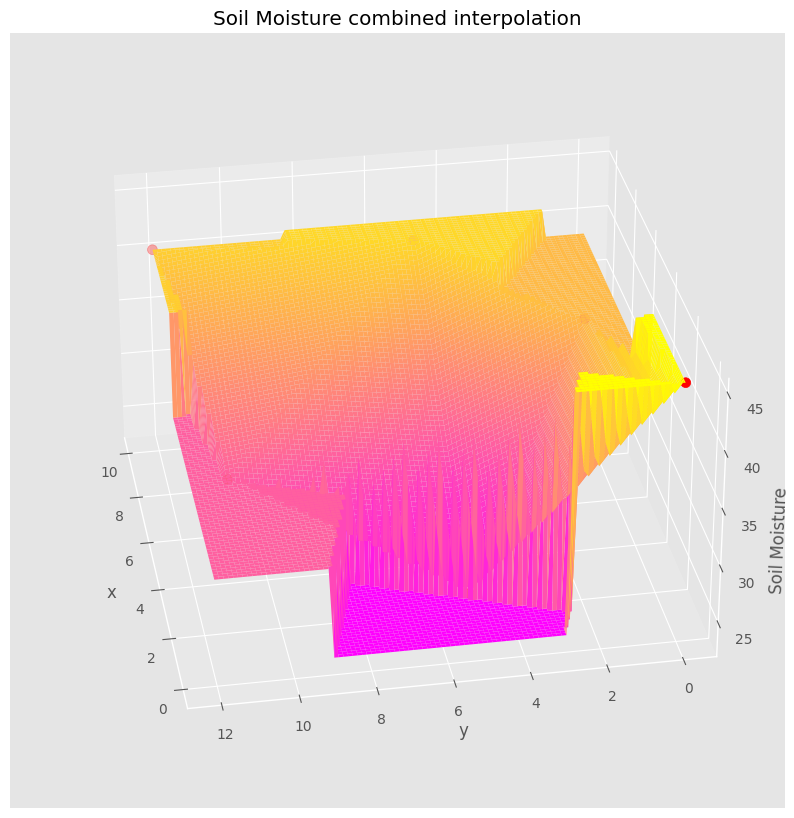

In [65]:
canon_grid = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid.plot_lin_neigh(fig_size=(10, 12), cmap='spring', azim= 170, elev= 30, color_bar=False,box_aspect=[1, 1, 0.6])

In [107]:
canon_grid.cell_size() # Retrouver la taille des cellules en x,y sur lesquelles la data assimilation peut être faite, 
#taille arbitraire en raison du manque de vraies données de coordonnées sur les sondes
# 100x100 cells de 0.10x0.12 dans l'exemple

(0.10101010101010102, 0.12121212121212122)

Les données d'humidité relativement à la parcelle de champ considéré peuvent être récupérées avec la fonction get_values() qui retourne x,y,z avec pour toute cellule en x[i],y[j] l'humidité est de z[i,j]

In [67]:
x,y,z = canon_grid.get_values()

df = pd.DataFrame()
for i in range(len(x)):
    for j in range(len(y)):
        row = {'x': x[i], 'y': y[j], 'humidity': z[j, i]}
        df = pd.concat([df, pd.DataFrame(row, index=[0])], ignore_index=True)

In [68]:
df.iloc[2500:2520]

,x,y,humidity
2500,2.525253,0.000000,44.780000
2501,2.525253,0.121212,44.780000
2502,2.525253,0.242424,44.780000
2503,2.525253,0.363636,44.780000
2504,2.525253,0.484848,42.069820
2505,2.525253,0.606061,41.567915
2506,2.525253,0.727273,41.066010
2507,2.525253,0.848485,40.564105
2508,2.525253,0.969697,40.062201
2509,2.525253,1.090909,39.560296


## Mesure de l'humidité en fonction du temps dans le champ pour chaque parcelle de champ

A partir des interpolation et extrapolation précédentent l'humidité locale pour chacune des 100x100 parcelles de champ considérées ici peut être estimée. Les coordonnées choisies pour les sondes canon étant arbitraires dans l'exemple, la connaissance précise des coordonnées de chacune des sondes utilisées dans l'étude rendrait les résultats plus cohérent, mais le fonctionnement reste montré par l'exemple.

In [110]:
n = len(canons_data[0]['humidity1']) # nombre de mesures par sonde

In [92]:
coord_z_list = [[] for i in range(6)]
canon_grid_list = [[] for i in range(6)]
humidity_values = [[] for i in range(6)] 
for l in range(1,7):
    for k in range(n):
        coord_z_list[l-1].append([canons_data[i]['humidity'+str(l)][k] for i in range(6)])
        canon_grid_list[l-1].append(Spatial_grid(coord_x, coord_y, coord_z_list[l-1][k])) # interpolation pour chaque cellule est chaque profondeur d'humidité
        humidity_values[l-1].append(canon_grid_list[l-1][k].get_values()[2])

In [127]:
cell_coord = (70,70) # cellule choisie parmis le 100x100 cellules
humidity_values[0][1000][cell_coord]

17.033816210889384

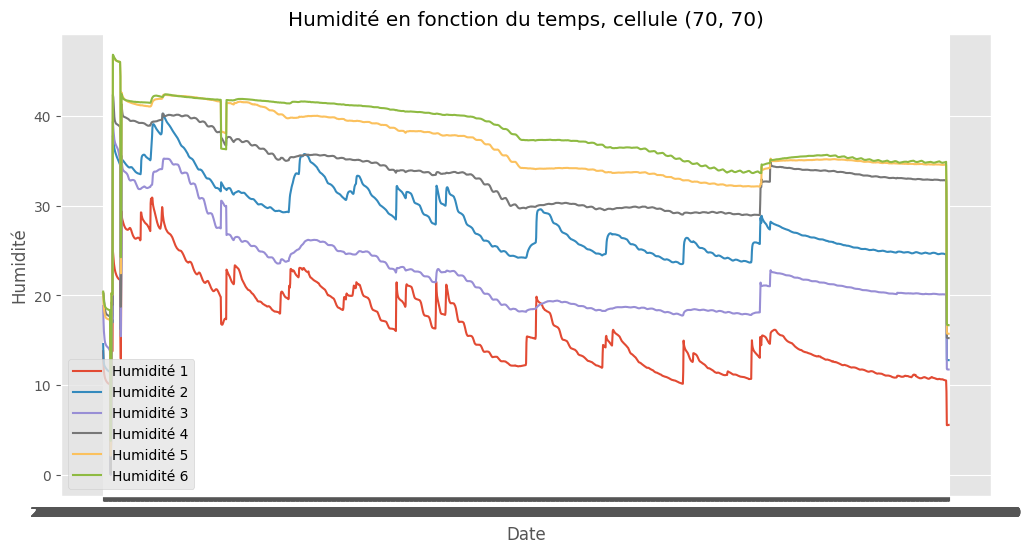

In [130]:
plt.figure(figsize=(12, 6))

for i in range(6):
    plt.plot(canons_data[0]['time'],[humidity_values[i][k][cell_coord] for k in range(n)], label=f'Humidité {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Humidité')
    plt.title('Humidité en fonction du temps, cellule {}'.format(cell_coord))
    plt.legend()
plt.show()

#### Mesures des sondes 

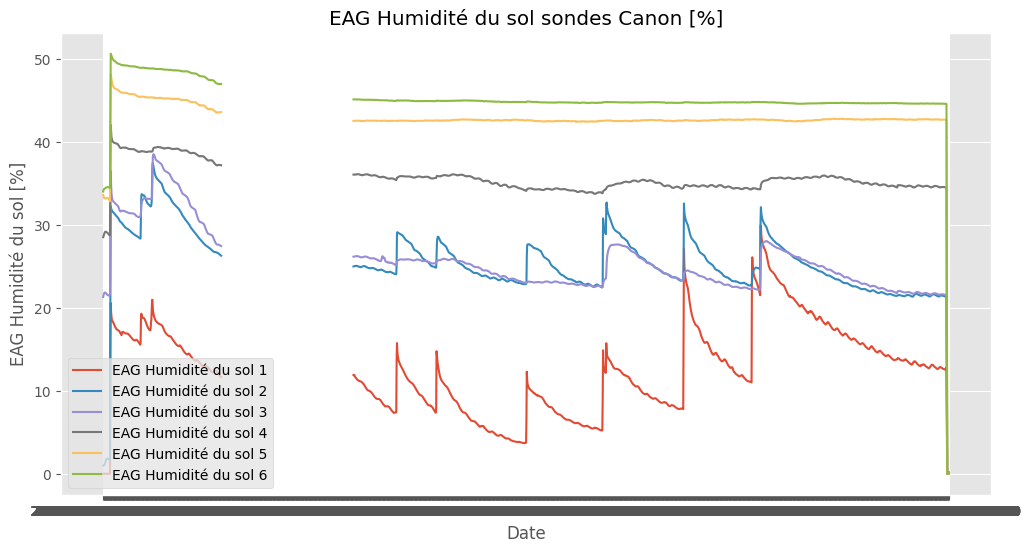

In [131]:
plt.figure(figsize=(12, 6))
i = 1
for k in range(1,7):
    plt.plot(canons_data[0]['time'], canons_data[0]['humidity'+str(k)], label = 'EAG Humidité du sol '+str(k))

plt.title("EAG Humidité du sol sondes Canon [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()
